# Weak IV Experiments

In [1]:
# Import relevant packages
using Pkg
Pkg.add("CSV"), using CSV
Pkg.add("DataFrames"), using DataFrames
Pkg.add("GLM"), using GLM
Pkg.add("FixedEffectModels"), using FixedEffectModels
Pkg.add("PrettyTables"), using PrettyTables
Pkg.add("CovarianceMatrices"), using CovarianceMatrices
Pkg.add("RegressionTables"), using RegressionTables
Pkg.add("StatsFuns"), using StatsFuns
Pkg.add("Plots"), using Plots
Pkg.add("MLBase"), using MLBase
Pkg.add("Seaborn"), using Seaborn
Pkg.add("Random"), using Random
Pkg.add("Statistics"), using Statistics

    Updating registry at `C:\Users\Work\.julia\registries\General.toml`


   Resolving package versions...


  No Changes to `C:\Users\Work\.julia\environments\v1.7\Project.toml`
  No Changes to `C:\Users\Work\.julia\environments\v1.7\Manifest.toml`


In [991]:
function foo1(a;rng=MersenneTwister(3))
  return randn(rng,a)
end

foo1 (generic function with 1 method)

In [992]:
function foo2(a;rng=MersenneTwister(1))
  return randn(rng,a)
end

foo2 (generic function with 1 method)

In [993]:
    B = 1000
    IVEst = zeros( B )
    n = 100
    beta = 0.25

    U = foo1(n)
    Z = foo2(n)
    D = beta*Z+U
    Y = D + U;
    intercept = ones(length(U))
    data1 = DataFrame(intercept = intercept, U = U, Z = Z, D = D, Y = Y);

    mod = reg(data1, @formula(D ~ Z))

                             Linear Model                             
Number of obs:                 100   Degrees of freedom:              2
R2:                          0.067   R2 Adjusted:                 0.057
F-Stat:                    7.01262   p-value:                     0.009
D           |  Estimate Std.Error  t value Pr(>|t|) Lower 95% Upper 95%
-----------------------------------------------------------------------
Z           |  0.250108  0.094447  2.64814    0.009 0.0626815  0.437535
(Intercept) | 0.0873342 0.0949433 0.919856    0.360 -0.101078  0.275746


In [994]:
IV =  reg(data1, @formula(Y ~ 0 + (D ~ Z)))
IV

                          IV Model                          
Number of obs:            100  Degrees of freedom:         1
R2:                     0.752  R2 Adjusted:            0.749
F-Stat:               6.79219  p-value:                0.011
F-Stat (First Stage): 7.01315  p-value (First Stage):  0.008
Y  | Estimate Std.Error t value Pr(>|t|) Lower 95% Upper 95%
------------------------------------------------------------
D  | 0.994509  0.381596 2.60618    0.011   0.23734   1.75168


In [995]:
IV.coef

1-element Vector{Float64}:
 0.994509337024402

Note that the instrument is weak here (contolled by $\beta$) -- the t-stat is less than 4.

## Run 1000 trials to evaluate distribution of the IV estimator

In [660]:
# dependent variable ~ exogenous variables + (endogenous variables ~ instrumental variables)

In [996]:
# Set seed
B = 1000
IVEst = zeros(B)


for i in 1:B
    
    U = randn( n)
    Z = randn( n)
    D = beta*Z+U
    Y = D + U
    intercept = ones(length(U))
    data2 = DataFrame(intercept = intercept, U = U, Z = Z, D = D, Y = Y);
        
    IV =  reg(data2, @formula(Y ~ + (D ~  Z)))
    
    IVEst[i,1] = IV.coef[2]
end

In [997]:
println(minimum(IVEst))
println(maximum(IVEst))

-40.368264648867964
57.83003936193075


In [998]:
IVEst

1000-element Vector{Float64}:
 -0.2633141021687235
  0.8948832260053269
 -0.20787697208091646
  0.6792079361265198
  1.052671004982911
 -0.7421608576444562
  1.1668318792400871
  0.933747261081341
  0.6850752909186767
  1.4639180207647025
 -0.9642817021998845
 -1.497309542643626
  1.2189323077695131
  ⋮
  5.460232661324924
  0.5478868710622211
  1.3717744154929605
  1.2644078444676423
  1.487865163308266
  0.7873831110483491
  0.7967961713080116
  0.9696312102644875
 -0.07785624411680934
  0.08917470799234822
  1.4232140851370487
  0.9943702695396225

## Plot the Actual Distribution against the Normal Approximation (based on Strong Instrument Assumption)

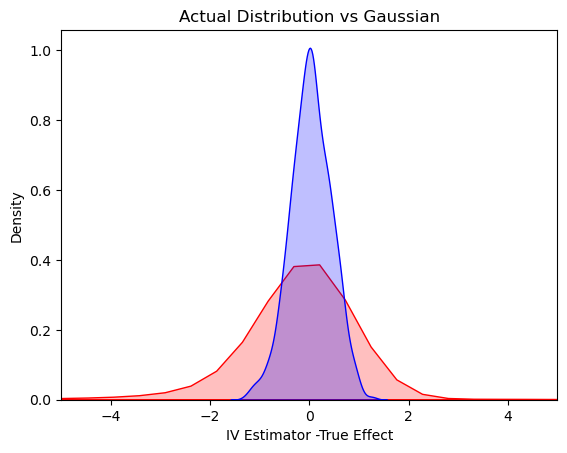

(-5.0, 5.0)

In [999]:
val = collect(range( -5, 5.5, step = 0.05 ))
var = (1/beta^2)*(1/100) # theoretical variance of IV
sd = sqrt(var)

μ=0; σ=sd
d = Normal(μ, σ)
normal_dist = rand(d,1000)

# plotting both distibutions on the same figure
Seaborn.kdeplot(x = IVEst.-1, shade = true, color = "red")
Seaborn.kdeplot(x = normal_dist, shade = true, color = "blue")
Seaborn.title("Actual Distribution vs Gaussian")
Seaborn.xlabel("IV Estimator -True Effect")
Seaborn.xlim(-5,5)